# PARAMETER IDENTIFICATION NOTEBOOK

In this notebook we leverage the pretrained surrogate models to identify fabrication uncertainties in MEMS accelerometers. We start from noisy signals. The noise is an additive white noise, manually added to the data to emulate experimental data. 

##### Importing necessary libraries

In [1]:
# Standard library imports
import sys

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# CUQI library imports
import cuqi
from cuqi.model import Model
from cuqi.distribution import Gaussian, Uniform, JointDistribution
from cuqi.sampler import MH, NUTS
from cuqi.geometry import Continuous1D, Discrete

# Local module imports
sys.path.append('../../src/SurrogateModeling')
sys.path.append('../../src/InverseProblems')
sys.path.append('../../src/utils')
from utils import * 


#### Decide sample to use for experimental data

In [2]:
sample = 10 # Which sample of the training set do wou want to take as experimental input?
OUTPUT_FILENAME = "./samples/sample_"+str(sample)

#### Set Bayesian Identification Parameters

In [3]:
# Surrogate Model Configurations
CONFIGURATION_I = './config_I.json'
CONFIGURATION_II = './config_II.json'

# Markov Chain Monte Carlo (MCMC) Configuration
MCMC_SETTINGS = {
    'parameter_start_points': [
        np.array([0.3, 0.0, 30.0]),
        np.array([0.4, 0.25, 30.0]),
        np.array([0.2, 0.25, 30.0]),
        np.array([0.4, -0.25, 30.0]),
        np.array([0.2, -0.25, 30.0])
    ],
    'bounds': ([0.1, -0.5, 29.0], [0.5, 0.5, 31.0]),
    'N': int(6e3),   # Total number of samples
    'Nb': int(1e3),  # Number of burn-in samples
    'Nt': 5,         # Number of chains
}

# Noise Configuration
NOISE_PARAMS = {
    'noise_factor': 1e-6 * 1000,
    'B': np.sqrt(200),
    'S': 5,
}

noise = (NOISE_PARAMS['noise_factor']*NOISE_PARAMS['B']*NOISE_PARAMS['S'])**2


#### Load Surrogate Models

In [4]:
# Data preprocessing for both configurations
data_processor_I = preprocessing(CONFIGURATION_I)
data_processor_II = preprocessing(CONFIGURATION_II)

# Initialize and load models for both configurations
model_I = NN_Model()
model_I.load_model(data_processor_I.config['MODEL_PATH'])

model_II = NN_Model()
model_II.load_model(data_processor_II.config['MODEL_PATH'])  # Ensure this uses data_processor_II

# Define forward and gradient functions for the first configuration
forward_model = create_forward_model_function(data_processor_I, model_I)
gradient_model = create_gradient_function(data_processor_I, model_I)

# Create a CUQI model using the forward model and gradient functions
cuqi_model = Model(forward=forward_model, 
                   jacobian=gradient_model,
                   range_geometry=Continuous1D(len(data_processor_I.time)),
                   domain_geometry=Discrete(["Overetch", "Offset", "Thickness"]))

# Extract test data for visualization or further processing
X_values, y_values = data_processor_I.X_test, data_processor_I.y_test



In [5]:
# Select a true sample for testing
x_true, y_true = X_values[sample], y_values[sample]

# Generate observed data by adding Gaussian noise to the true data
y_observed = Gaussian(mean=y_true, cov=noise * np.eye(len(data_processor_I.time))).sample()

# Define the prior distribution for the input parameters
# Assuming uniform distributions over specified ranges for each parameter
x_distribution = Uniform(low=np.array([0.1, -0.5, 29.0]), high=np.array([0.5, 0.5, 31.0]))

# Define the likelihood distribution for the output
# Gaussian distribution centered around the model's predictions with specified noise
y_distribution = Gaussian(mean=cuqi_model(x_distribution), cov=noise * np.eye(len(data_processor_I.time)))
          

#### Perform least square optimization for each starting point

In [6]:
# Initialize a list to hold the optimized parameters for each start point
initial_guesses = []

# Display the true parameters for reference
print("Real Params: ", x_true)

# Iterate over each parameter start point to perform optimization
for index, start_point in enumerate(MCMC_SETTINGS['parameter_start_points']):
    # Perform least squares optimization given the observed data, forward model,
    # start point, and parameter bounds
    optimized_params, covariance_matrix = least_squares_optimization(
        y_observed=y_observed, 
        forward_model=forward_model, 
        start_point=start_point, 
        bounds=MCMC_SETTINGS['bounds']
    )

    # Append the optimized parameters to the list of initial guesses
    initial_guesses.append(optimized_params)

    # Print the optimized parameters for this iteration
    print(f"Optimized Params {index + 1}: {optimized_params}")


Real Params:  [ 0.345976 -0.423282 30.139451]
Optimized Params 1: [ 0.34723005 -0.42252053 30.29265772]
Optimized Params 2: [ 0.34702363 -0.42270203 30.2632811 ]
Optimized Params 3: [ 0.34690979 -0.42282611 30.24511241]
Optimized Params 4: [ 0.3477191  -0.42248989 30.32913562]
Optimized Params 5: [ 0.34683866 -0.42269135 30.25136949]


#### Do Metropolis Hastings Sampling

In [7]:
# Define the covariance matrix for the Markov chain sampling, scaled by the noise factor
cov_matrix = covariance_matrix

# Set up the posterior distribution by combining the prior (x_distribution)
# and the likelihood (y_distribution) given the observed data (y_observed)
posterior = JointDistribution(x_distribution, y_distribution)(y_distribution=y_observed)

# Initialize a list to hold the Markov chain samples for each initial guess
samples_mh = []

# Iterate over each initial guess to set up and run the Markov chain sampler
for index, initial_guess in enumerate(initial_guesses):
    # Set up the Markov chain sampler with the posterior, covariance matrix, and initial guessi
    proposal = Gaussian(mean=np.zeros(3), cov=cov_matrix)
    mc_sampler =  MH(target=posterior, proposal=proposal, x0=initial_guess)
    samples = mc_sampler.sample_adapt(MCMC_SETTINGS['N'], 0)  # Assuming 'N' is the number of samples desired
    
    # Append the samples to the list
    samples_mh.append(samples)
    
    # Compute and print the Effective Sample Size (ESS) of the first set of samples
    print("Effective Sample Size: ", samples_mh[index].burnthin(MCMC_SETTINGS['Nb'],MCMC_SETTINGS['Nt']).compute_ess(),"\n")

# Computing diagnostics and collecting results
print("Rhat: ", samples_mh[0].compute_rhat(samples_mh[1:]))

# Save the numpy array to a file
np.save(OUTPUT_FILENAME, samples_mh[0].samples)  

Sample 6000 / 6000

Average acceptance rate: 0.2785 MCMC scale: 0.12869977424381593 

Effective Sample Size:  [402.81381131 389.20294702 371.99513605] 

Sample 6000 / 6000

Average acceptance rate: 0.2745 MCMC scale: 0.12784138993085084 

Effective Sample Size:  [314.57709004 360.71395954 280.89976783] 

Sample 6000 / 6000

Average acceptance rate: 0.27266666666666667 MCMC scale: 0.1312555273640875 

Effective Sample Size:  [464.48772352 334.75464817 349.48942163] 

Sample 6000 / 6000

Average acceptance rate: 0.2765 MCMC scale: 0.1323352094434628 

Effective Sample Size:  [347.96969579 240.19364506 223.16764703] 

Sample 6000 / 6000

Average acceptance rate: 0.2715 MCMC scale: 0.12851618984824448 

Effective Sample Size:  [296.66409397 226.53380567 199.35104538] 

Rhat:  [1.0009325  1.00201957 1.00198444]


Let's look at the trace plot of one chain

array([[<Axes: title={'center': 'Offset'}>,
        <Axes: title={'center': 'Offset'}>],
       [<Axes: title={'center': 'Overetch'}>,
        <Axes: title={'center': 'Overetch'}>],
       [<Axes: title={'center': 'Thickness'}>,
        <Axes: title={'center': 'Thickness'}>]], dtype=object)

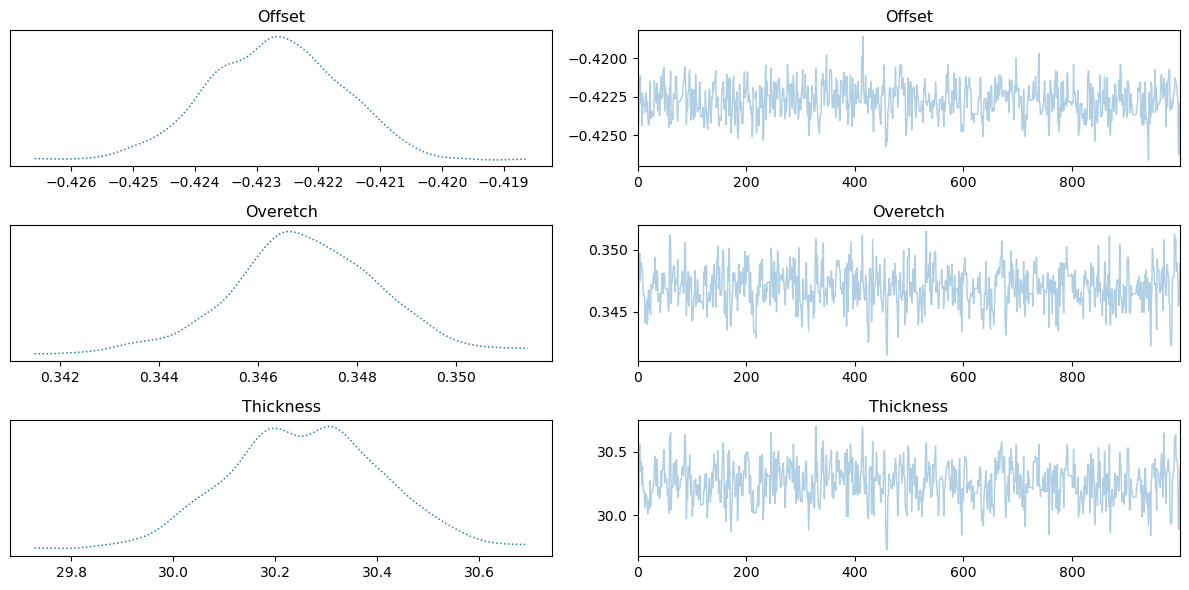

In [8]:
# Plot trace of the first set of samples
samples_mh[0].burnthin(MCMC_SETTINGS['Nb'],MCMC_SETTINGS['Nt']).plot_trace()

Let's compare the prediction of the mean parameter combination and the experimental signal

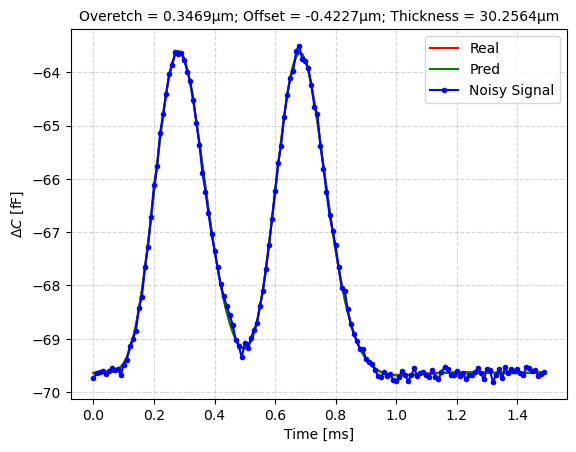

In [9]:
# Plotting and data collection
plot_results(data_processor_I.time, forward_model(x_true), y_observed, forward_model, samples_mh[0])


Finally, let's look at the parameters distribution

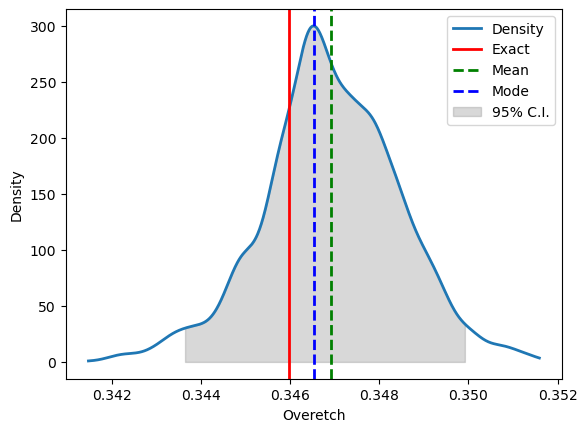

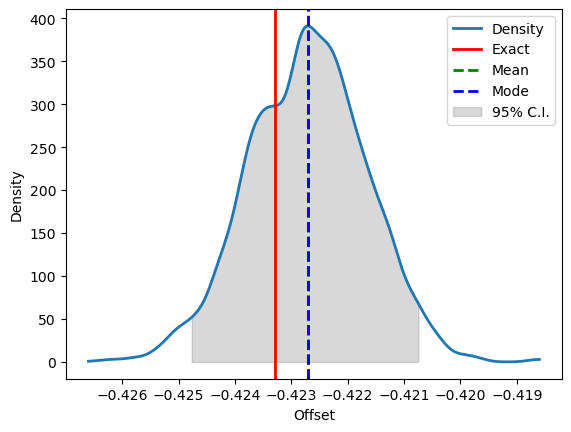

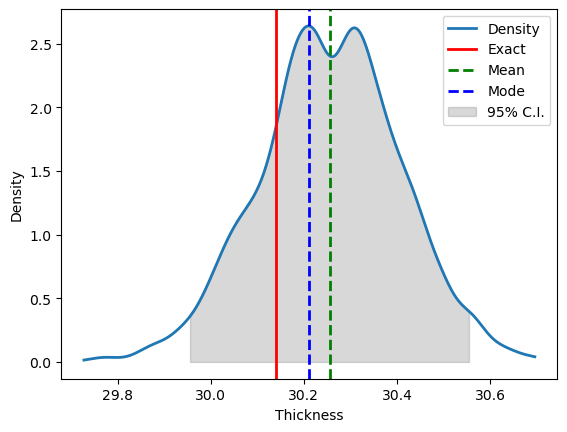

In [10]:
for j in range(3):
    plot_parameter_distribution(samples_mh[0].samples[j, :], x_true[j], ['Overetch', 'Offset', 'Thickness'][j])

# Post Processing Plots

This section generates the plots in the paper.

In [11]:
from plotsPaper import *
samples = np.load(OUTPUT_FILENAME+'.npy')

##### Histograms of the geometric parameters

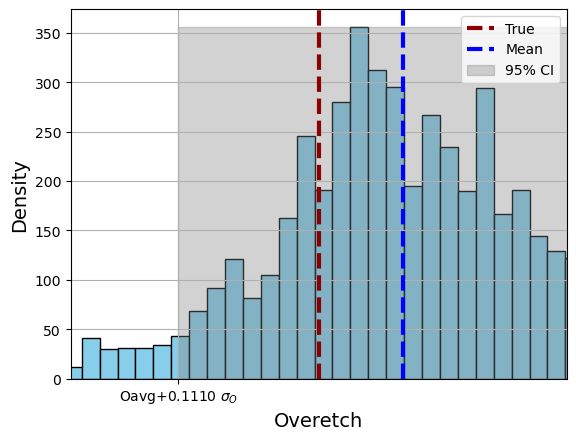

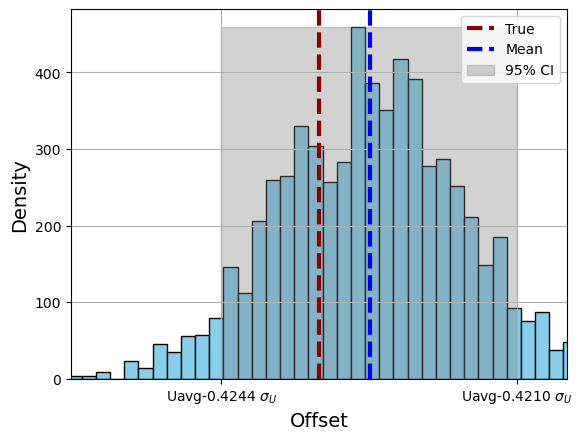

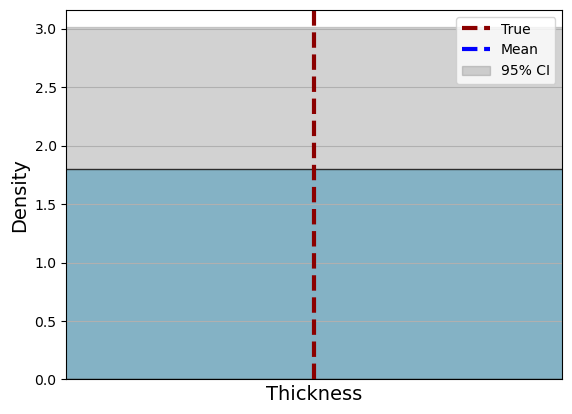

In [12]:
plot_histograms(samples, x_true)

ciao


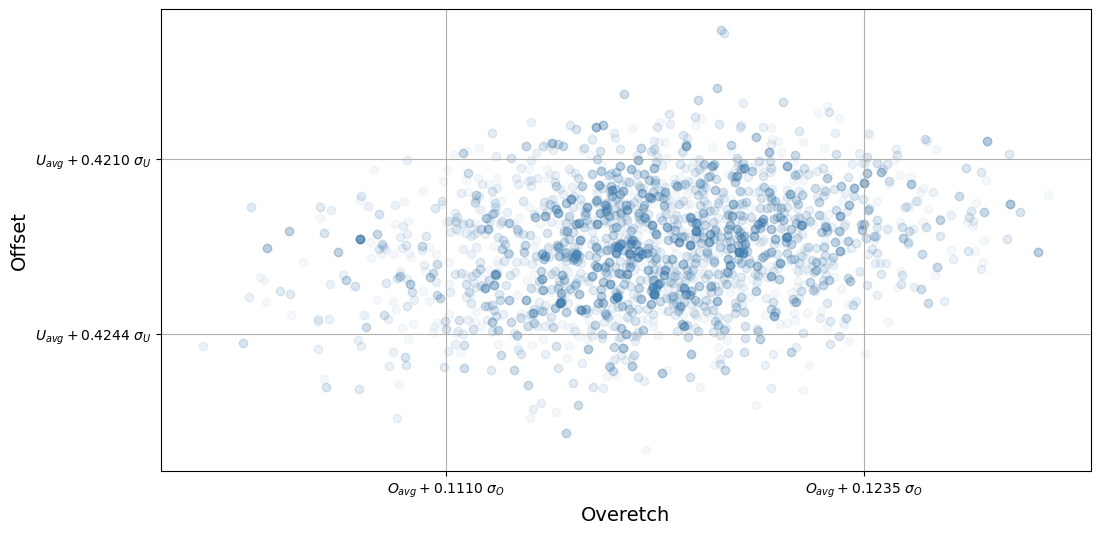

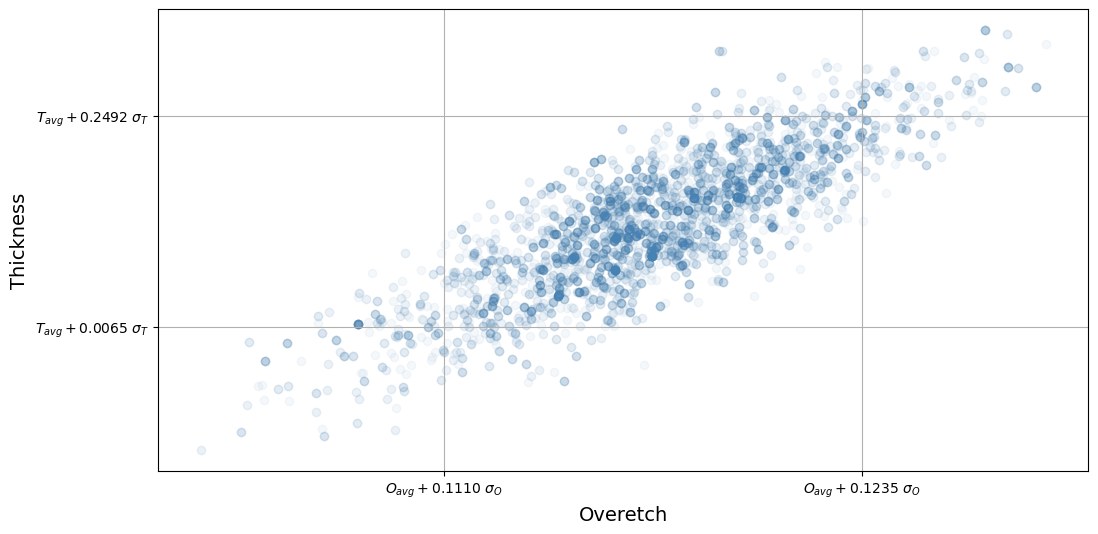

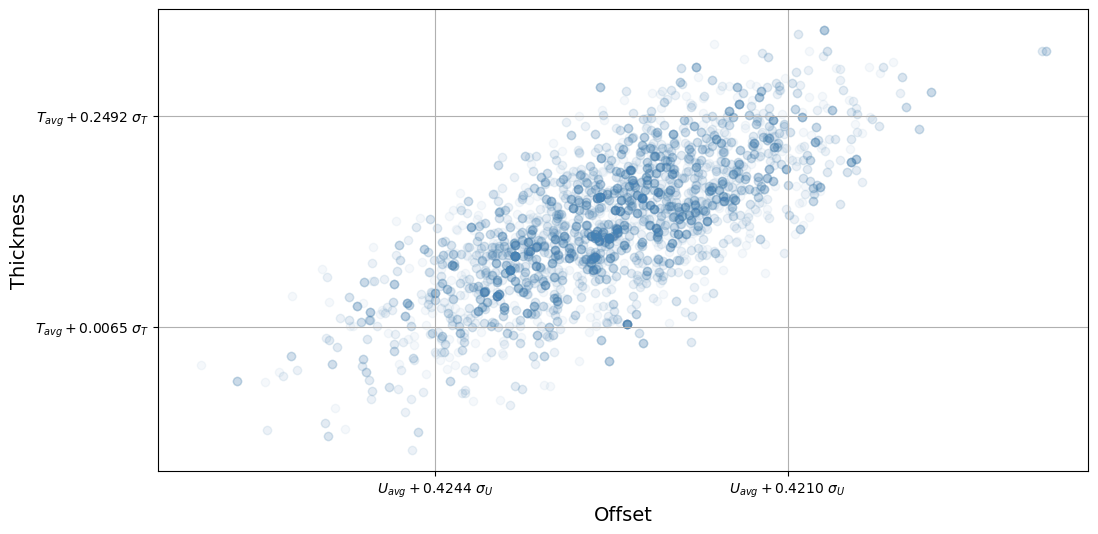

In [13]:
plot_scatter(samples)

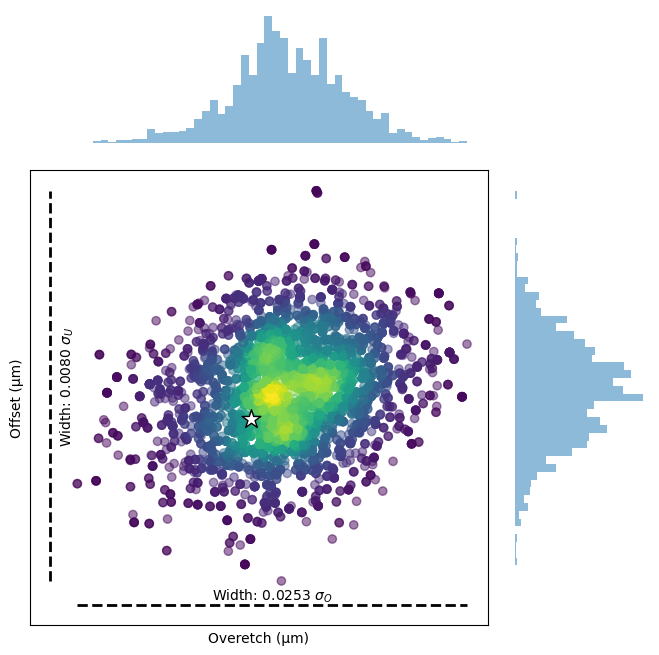

In [14]:
plot_density_scatter(samples, x_true, sigma_values=(0.2, 0.5))  # Adjust sigma values as needed


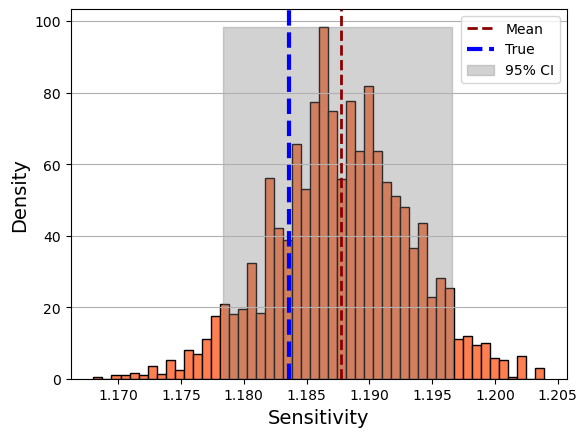

In [15]:
S_true = data_processor_II.y_test[sample]

plot_sensitivity_histogram(samples, S_true, model_II, data_processor_II.scaler)

# Results for different noise levels


In [16]:
noise_factors = [100, 1000, 10000]

for i in range(3):
    
    # Noise Configuration
    NOISE_PARAMS = {
        'noise_factor': 1e-6 * noise_factors[i],
        'B': np.sqrt(200),
        'S': 5,
    }


    noise = (NOISE_PARAMS['noise_factor']*NOISE_PARAMS['B']*NOISE_PARAMS['S'])**2

    # Select a true sample for testing
    x_true, y_true = X_values[sample], y_values[sample]

    # Generate observed data by adding Gaussian noise to the true data
    y_observed = Gaussian(mean=y_true, cov=noise * np.eye(len(data_processor_I.time))).sample()

    # Define the prior distribution for the input parameters
    # Assuming uniform distributions over specified ranges for each parameter
    x_distribution = Uniform(low=np.array([0.1, -0.5, 29.0]), high=np.array([0.5, 0.5, 31.0]))

    # Define the likelihood distribution for the output
    # Gaussian distribution centered around the model's predictions with specified noise
    y_distribution = Gaussian(mean=cuqi_model(x_distribution), cov=noise * np.eye(len(data_processor_I.time)))

    # Initialize a list to hold the optimized parameters for each start point
    initial_guesses = []

    # Display the true parameters for reference
    print("Real Params: ", x_true)

    # Iterate over each parameter start point to perform optimization
    for index, start_point in enumerate(MCMC_SETTINGS['parameter_start_points'][:1]):
        # Perform least squares optimization given the observed data, forward model,
        # start point, and parameter bounds
        optimized_params, covariance_matrix = least_squares_optimization(
            y_observed=y_observed, 
            forward_model=forward_model, 
            start_point=start_point, 
            bounds=MCMC_SETTINGS['bounds']
        )

        # Append the optimized parameters to the list of initial guesses
        initial_guesses.append(optimized_params)

        # Print the optimized parameters for this iteration
        print(f"Optimized Params {index + 1}: {optimized_params}")

        # Define the covariance matrix for the Markov chain sampling, scaled by the noise factor
    if i == 0:
        cc = 0.01
    else:
        cc = 1.0

    cov_matrix = cc*covariance_matrix

    # Set up the posterior distribution by combining the prior (x_distribution)
    # and the likelihood (y_distribution) given the observed data (y_observed)
    posterior = JointDistribution(x_distribution, y_distribution)(y_distribution=y_observed)

    # Initialize a list to hold the Markov chain samples for each initial guess
    samples_mh = []

    # Iterate over each initial guess to set up and run the Markov chain sampler
    for index, initial_guess in enumerate(initial_guesses):
        # Set up the Markov chain sampler with the posterior, covariance matrix, and initial guessi
        proposal = Gaussian(mean=np.zeros(3), cov=cov_matrix)
        mc_sampler =  MH(target=posterior, proposal=proposal, x0=initial_guess)
        samples = mc_sampler.sample_adapt(MCMC_SETTINGS['N'], 0)  # Assuming 'N' is the number of samples desired
        
        # Append the samples to the list
        samples_mh.append(samples)
        
        # Compute and print the Effective Sample Size (ESS) of the first set of samples
        print("Effective Sample Size: ", samples_mh[index].burnthin(MCMC_SETTINGS['Nb'],MCMC_SETTINGS['Nt']).compute_ess(),"\n")

    # Computing diagnostics and collecting results
    print("Rhat: ", samples_mh[0].compute_rhat(samples_mh[1:]))

    samples_to_save = samples_mh[0].burnthin(MCMC_SETTINGS['Nb'],MCMC_SETTINGS['Nt'])

    # Save the numpy array to a file
    OUTPUT_FILENAME = "./samples/sample_"+str(sample)+"_noise_level_1e"+str(i+1)
    np.save(OUTPUT_FILENAME, samples_to_save.samples)  



Real Params:  [ 0.345976 -0.423282 30.139451]
Optimized Params 1: [ 0.34632903 -0.42286119 30.19842645]
Sample 5940 / 6000

arviz - WARNING - Shape validation failed: input_shape: (1, 6000), minimum_shape: (chains=2, draws=4)


Sample 6000 / 6000

Average acceptance rate: 0.2703333333333333 MCMC scale: 0.12819440797671056 

Effective Sample Size:  [375.61768038 349.46292487 326.5914202 ] 

Rhat:  [nan nan nan]
Real Params:  [ 0.345976 -0.423282 30.139451]
Optimized Params 1: [ 0.3465089  -0.42511296 30.02695288]
Sample 6000 / 6000

Average acceptance rate: 0.27616666666666667 MCMC scale: 0.13184790022708617 

Effective Sample Size:  [421.02868916 377.32590953 351.31390895] 

Rhat:  [nan nan nan]
Real Params:  [ 0.345976 -0.423282 30.139451]
Optimized Params 1: [ 0.34143093 -0.43368621 29.00122712]
Sample 6000 / 6000

Average acceptance rate: 0.5296666666666666 MCMC scale: 0.592686369942058 

Effective Sample Size:  [180.7498508  204.6703659  536.63808514] 

Rhat:  [nan nan nan]


5.255
5.2635474
5.25918300151825
5.267640018463135
5.2432213
5.202702522277832
5.287272596359253
5.230253
5.101526117324829
5.3938682079315186
[array([ 0.34632206, -0.42284496, 30.199288  ]), array([ 0.34644674, -0.42507601, 30.02623644]), array([ 0.35084887, -0.43253267, 29.73810829])]
[array([ 0.3459826 , -0.4230467 , 30.16886168]), array([ 0.34346497, -0.42716463, 29.72640102]), array([ 0.33355612, -0.44873887, 29.03387751])]
[array([ 0.34661571, -0.42263917, 30.22835084]), array([ 0.3497347 , -0.42282333, 30.36573259]), array([ 0.36933956, -0.41771768, 30.85066669])]


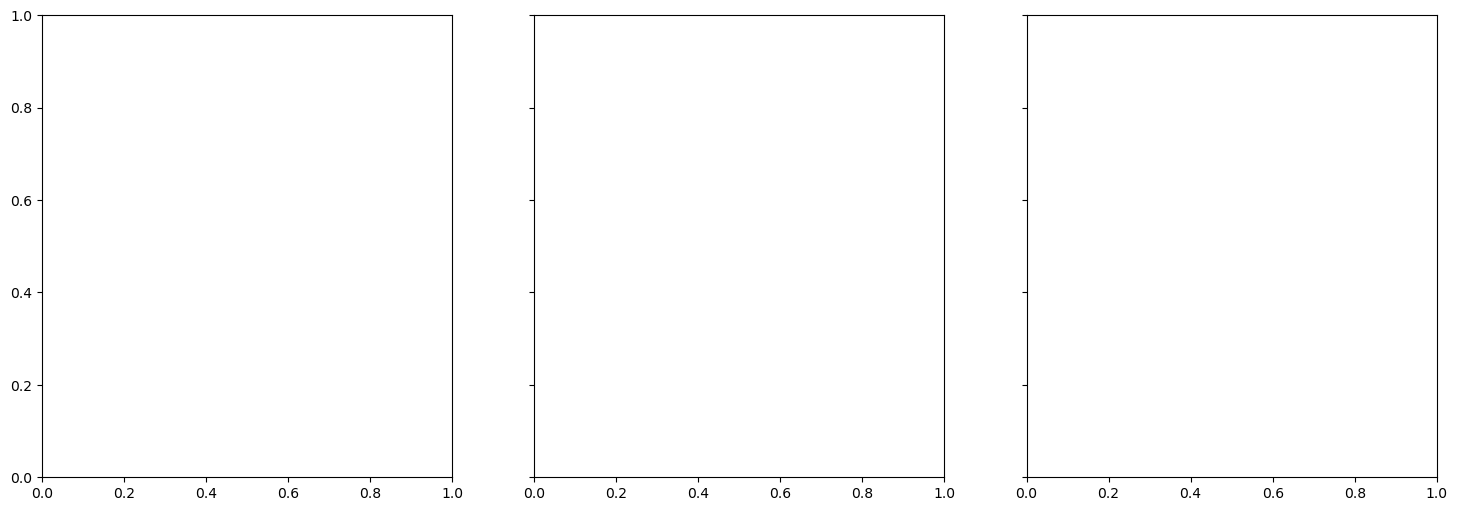

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define noise factors and corresponding labels
noise_factors = [100, 1000, 10000]
noise_labels = ["1e-4", "1e-3", "1e-2"]

# True parameter values for reference
true_params = np.array([0.345976, -0.423282, 30.139451])

# Create a figure and axes for the plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

means = []
ci_lowers = []
ci_uppers = []

print(S_true)

# Load and process samples for each noise level
for i, noise_factor in enumerate(noise_factors):
    # Load the samples
    samples = np.load(f"./samples/sample_{sample}_noise_level_1e{i+1}.npy")

    # Plot the posterior distributions for each parameter
    # Calculate mean and 95% confidence intervals for each parameter
    mean_value = np.mean(samples, axis=1)
    ci_lower = np.percentile(samples, 2.5, axis=1)
    ci_upper = np.percentile(samples, 97.5, axis=1)

    sample_transposed = samples.T
    sample_transposed = data_processor_II.scaler.transform(sample_transposed)
    predicted_sensitivities = model_II.predict(sample_transposed).flatten()

    mean_sensitivity = np.mean(predicted_sensitivities)
    ci_lower_s, ci_upper_s = np.percentile(predicted_sensitivities, [5, 95])

    print(mean_sensitivity)
    print(ci_lower_s)
    print(ci_upper_s)
    

    means.append(mean_value)
    ci_lowers.append(ci_lower)
    ci_uppers.append(ci_upper)

print(means)
print(ci_lowers)
print(ci_uppers)




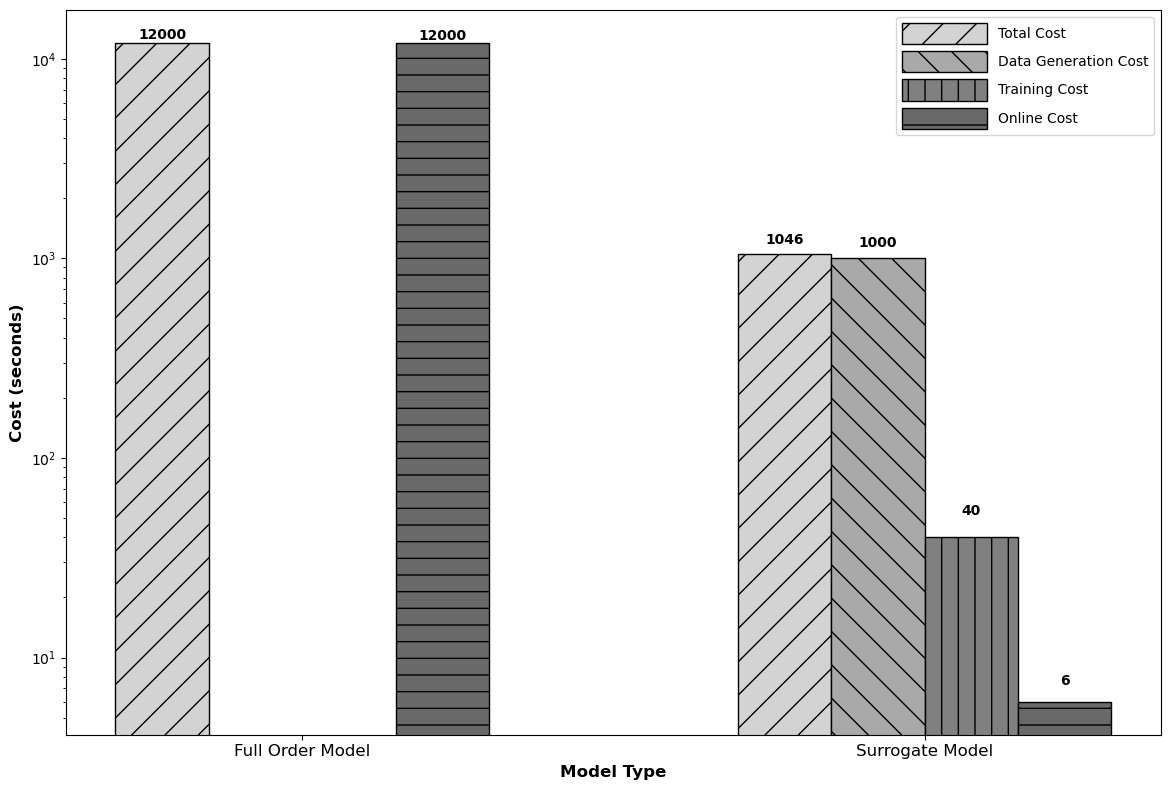

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Cost values
full_order_simulation_cost = 2 * 6000  # 20 seconds per simulation times 6000 simulations

# Surrogate model costs
data_generation_cost = 2 * 500  # 20 seconds per simulation times 500 simulations
training_cost = (4e-3 * 10000)  # 4 ms times 10000 iterations, converted to seconds
online_cost = (1e-3 * 6000)  # 1 ms times 6000 evaluations, converted to seconds

# Total costs for surrogate model
surrogate_offline_cost = data_generation_cost + training_cost
surrogate_online_cost = online_cost
surrogate_total_cost = surrogate_offline_cost + surrogate_online_cost

# Labels and values
labels = ['Full Order Model', 'Surrogate Model']
total_costs = [full_order_simulation_cost, surrogate_total_cost]
data_generation_costs = [0, data_generation_cost]
training_costs = [0, training_cost]
online_costs = [full_order_simulation_cost, surrogate_online_cost]

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Bar width
bar_width = 0.15

# Position of bars
r1 = np.arange(len(labels))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Creating bars with patterns and shades of gray
patterns = ['/', '\\', '|', '-']
colors = ['lightgray', 'darkgray', 'gray', 'dimgray']



for idx, (r, costs, label) in enumerate(zip([r1, r2, r3, r4], [total_costs, data_generation_costs, training_costs, online_costs], ['Total Cost', 'Data Generation Cost', 'Training Cost', 'Online Cost'])):
    plt.bar(r, costs, color=colors[idx], width=bar_width, edgecolor='black', label=label, hatch=patterns[idx])

# Customize the plot
plt.xlabel('Model Type', fontweight='bold', fontsize=12)
plt.ylabel('Cost (seconds)', fontweight='bold', fontsize=12)
plt.xticks([r + 1.5*bar_width for r in range(len(labels))], labels, fontsize=12)
plt.legend(handlelength=6.125, handleheight=2)  # Adjust handle length and height

# Adding the cost labels on top of the bars
for i in range(len(labels)):
    plt.text(r1[i], total_costs[i] + 100, f'{total_costs[i]:.0f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    if data_generation_costs[i] != 0:
        plt.text(r2[i], data_generation_costs[i] + 100, f'{data_generation_costs[i]:.0f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    if training_costs[i] != 0:
        plt.text(r3[i], training_costs[i] + 10, f'{training_costs[i]:.0f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    plt.text(r4[i], online_costs[i] + 1, f'{online_costs[i]:.0f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Display the plot
plt.tight_layout()
plt.yscale('log')
plt.show()